In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [38]:
np.random.seed(42)
num_samples = 10000
x_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
t_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
u_exact = np.sin(np.pi * x_train) * np.exp(-np.pi**2 * t_train)

# Convert to TensorFlow tensors
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
u_exact_tf = tf.convert_to_tensor(u_exact, dtype=tf.float32)


# Combine x and t for training input
input_train = tf.concat([x_train_tf, t_train_tf], axis=1)


# Generate test data for prediction
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
t_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Convert to TensorFlow tensors
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test_tf = tf.convert_to_tensor(t_test, dtype=tf.float32)

input_test = tf.concat([x_test_tf, t_test_tf], axis=1)

u_exact_test = np.sin(np.pi * x_test) * np.exp(-np.pi**2 * t_test)
u_exact_test_tf = tf.convert_to_tensor(u_exact_test, dtype=tf.float32)


In [40]:
class PINNs(tf.keras.Model):
    def __init__(self):
        super(PINNs, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='relu')
        self.dense2 = tf.keras.layers.Dense(50, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = inputs[:, 0:1]
        t = inputs[:, 1:2]
        concat_input = tf.concat([x, t], axis=1)
        hidden1 = self.dense1(concat_input)
        hidden2 = self.dense2(hidden1)
        output = self.output_layer(hidden2)
        return output


In [42]:
def physics_loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u_pred = model(tf.concat([x, t], axis=1))
        u_x = tape.gradient(u_pred, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u_pred, t)
        del tape

    alpha = 0.01

    
    pde_loss = u_t - alpha * u_xx

    return tf.reduce_mean(tf.square(pde_loss))

In [44]:
model = PINNs()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
num_epochs = 20000
loss_history = []
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        physics_loss_value = physics_loss(model, x_train_tf, t_train_tf)
        data_loss_value = tf.reduce_mean(tf.square(model(input_train) - u_exact_tf))
        total_loss = physics_loss_value + data_loss_value

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    loss_history.append(total_loss.numpy())

    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss.numpy()}, Physics Loss: {physics_loss_value.numpy()}, Data Loss: {data_loss_value.numpy()}")


plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PINNs Training Loss")
plt.semilogy()  # Use a logarithmic scale for the y-axis
plt.show()

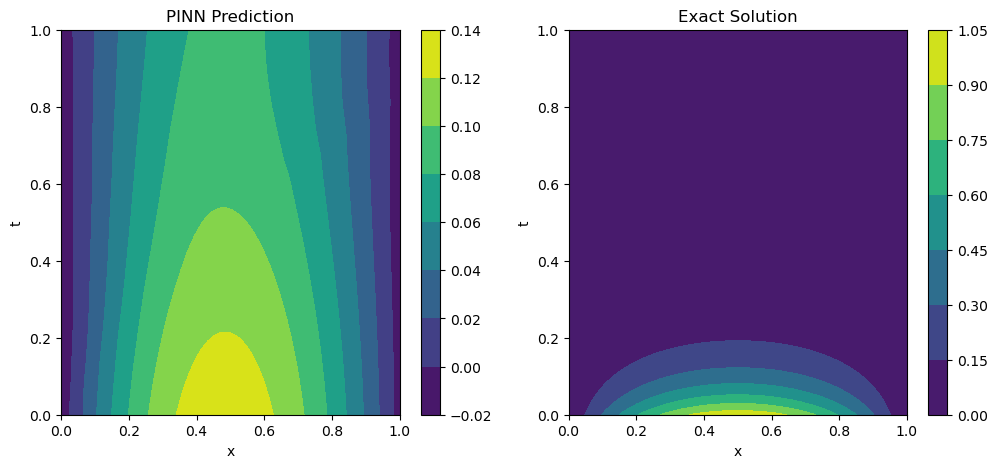

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

X_test, T_test = np.meshgrid(x_test, t_test)
x_test_flat = np.hstack((X_test.flatten()[:, None], T_test.flatten()[:, None]))

# Get PINN predictions
u_pred = model(x_test_flat).numpy() 
u_pred = u_pred.reshape(X_test.shape)  # Reshape to match grid


def exact_solution(x, t):
    # Example: Solution to a simple diffusion equation
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x) 


u_exact = exact_solution(X_test, T_test)

c1 = ax[0].contourf(X_test, T_test, u_pred, cmap='viridis')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_title('PINN Prediction')
fig.colorbar(c1, ax=ax[0])

# Exact solution plot
c2 = ax[1].contourf(X_test, T_test, u_exact, cmap='viridis')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_title('Exact Solution')
fig.colorbar(c2, ax=ax[1])

plt.show()